# Цель занятия 1. Ознакомление с методом наименьших квадратов
# (МНК) как с эффективным способом построения регрессионной модели
# для задач прогнозирования, оценки статистической зависимости и анализа данных по выборкам. 

Задание на занятие 1 (ЛИНЕЙНАЯ РЕГРЕССИЯ). 

In [12]:
import numpy as np          # Основные математические операции и работа с массивами
import matplotlib.pyplot as plt  # Визуализация данных
from scipy.stats import (    # Статистические функции:
    multivariate_normal,     # Многомерное нормальное распределение
    pearsonr,                # Коэффициент корреляции Пирсона
    t                        # t-распределение для доверительных интервалов
)

1а) Генерация коррелированных данных

In [13]:
np.random.seed(42)  # Фиксация случайных значений для воспроизводимости
n = 200             # Объем выборки: влияет на точность оценок
mu = [0, 2]         # Истинные средние значения [X, Y]
sigma_x = 1.0       # Стандартное отклонение X
sigma_y = 0.5       # Стандартное отклонение Y
rho = 0.8           # Целевой коэффициент корреляции

# Ковариационная матрица (формула cov(X,Y)=ρ*σ_x*σ_y)
cov_matrix = [
    [sigma_x**2, rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
]

# Генерация данных из многомерного нормального распределения
data = np.random.multivariate_normal(
    mean=mu,        # Вектор средних
    cov=cov_matrix, # Ковариационная структура
    size=n          # Количество наблюдений
)
X, Y = data[:, 0], data[:, 1]  # Разделение на переменные X и Y

1б) Выборочные характеристики

In [14]:
mu_x_hat = np.mean(X)  # Оценка математического ожидания X
mu_y_hat = np.mean(Y)  # Оценка математического ожидания Y

# Несмещённые оценки дисперсий (ddof=1 дает denominator n-1)
var_x_hat = np.var(X, ddof=1)  # Оценка Var(X)
var_y_hat = np.var(Y, ddof=1)  # Оценка Var(Y)

# Проверка точности оценок
print("[1б] Проверка средних:")
print(f"X: Оценка {mu_x_hat:.3f} | Истинное {mu[0]} | Ошибка {abs(mu_x_hat - mu[0]):.3f}")
print(f"Y: Оценка {mu_y_hat:.3f} | Истинное {mu[1]} | Ошибка {abs(mu_y_hat - mu[1]):.3f}")

[1б] Проверка средних:
X: Оценка -0.011 | Истинное 0 | Ошибка 0.011
Y: Оценка 2.007 | Истинное 2 | Ошибка 0.007


1в) МНК-регрессия

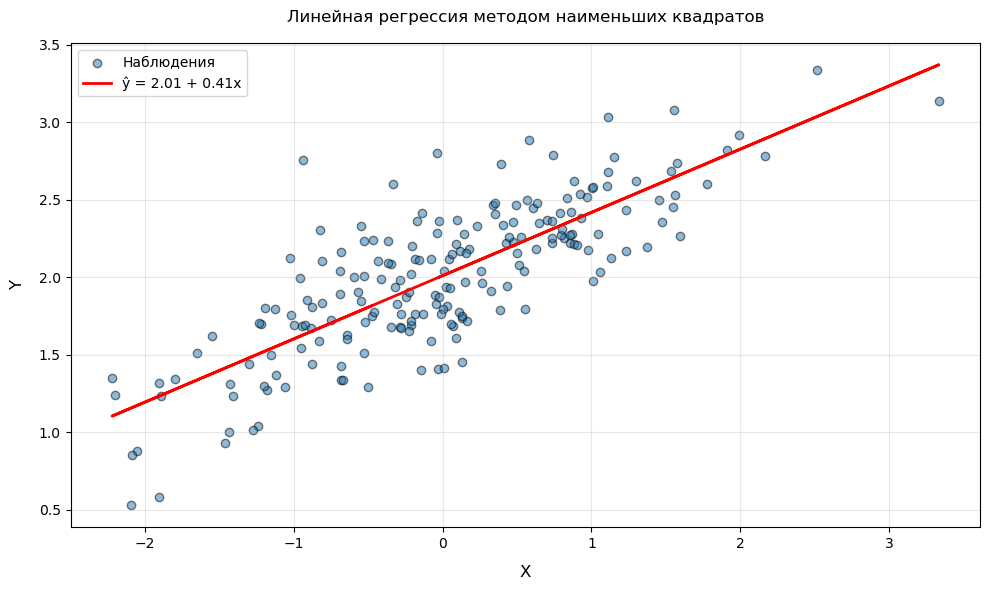

In [15]:
# Расчет коэффициентов по формулам:
# β1 = Cov(X,Y)/Var(X)
# β0 = μ_Y - β1*μ_X
cov_xy = np.cov(X, Y, ddof=1)[0, 1]  # Выборочная ковариация
var_x = np.var(X, ddof=1)            # Выборочная дисперсия X
beta1 = cov_xy / var_x               # Наклон регрессии
beta0 = mu_y_hat - beta1 * mu_x_hat  # Свободный член

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, 
            alpha=0.5, 
            label='Наблюдения', 
            edgecolor='k')  # Диаграмма рассеяния
plt.plot(X, beta0 + beta1*X, 
         'r-', 
         linewidth=2, 
         label=f'ŷ = {beta0:.2f} + {beta1:.2f}x')  # Линия регрессии
plt.title('Линейная регрессия методом наименьших квадратов', pad=15)
plt.xlabel('X', fontsize=12, labelpad=10)
plt.ylabel('Y', fontsize=12, labelpad=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

1г) Оценка корреляции

In [16]:
# Расчет через коэффициент регрессии: ρ = β1 * σ_X / σ_Y
rho_hat_reg = beta1 * (np.std(X, ddof=1)/np.std(Y, ddof=1))

# Расчет с помощью функции pearsonr
rho_pearson, p_value = pearsonr(X, Y)  # (коэф.корр., p-value)

print("\n[1г] Проверка корреляции:")
print(f"Через регрессию: {rho_hat_reg:.4f}")
print(f"Пирсон: {rho_pearson:.4f}")
print(f"Истинная: {rho} | Ошибка: {abs(rho_hat_reg - rho):.4f}")


[1г] Проверка корреляции:
Через регрессию: 0.8018
Пирсон: 0.8018
Истинная: 0.8 | Ошибка: 0.0018


1д) Анализ качества модели

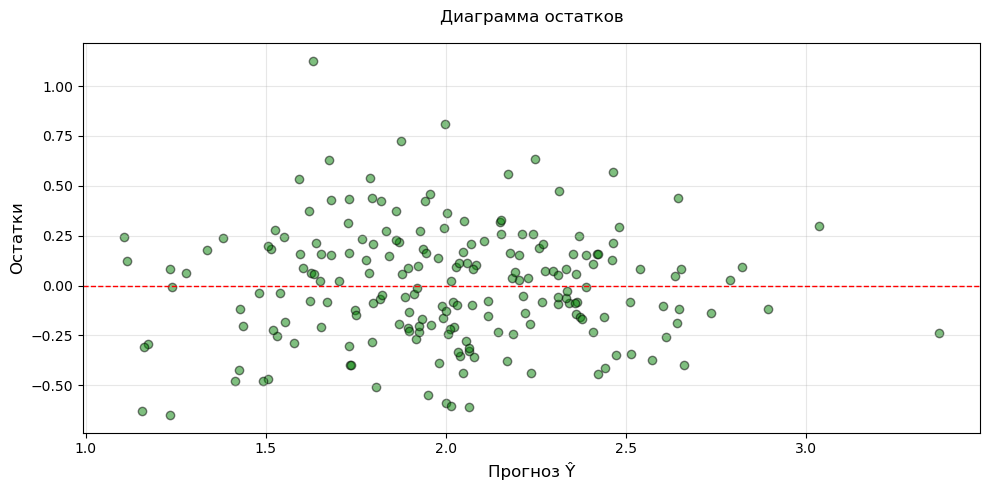

In [17]:
Y_pred = beta0 + beta1 * X     # Прогнозные значения
residuals = Y - Y_pred         # Остатки (разница между фактом и прогнозом)

SSE = np.sum(residuals**2)     # Сумма квадратов ошибок (SSE)
SST = np.sum((Y - mu_y_hat)**2)  # Общая сумма квадратов (SST)
R2 = 1 - SSE/SST               # Коэффициент детерминации

# График остатков
plt.figure(figsize=(10, 5))
plt.scatter(Y_pred, residuals, 
           alpha=0.5, 
           color='green',
           edgecolor='k')  # Остатки vs. прогноз
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Диаграмма остатков', pad=15)
plt.xlabel('Прогноз Ŷ', fontsize=12)
plt.ylabel('Остатки', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

1е) Исследование параметров

In [18]:
def generate_and_fit(n, mu_x, sigma_x, mu_y, sigma_y, rho):
    """Генерирует данные и оценивает параметры регрессии"""
    # Генерация ковариационной матрицы
    cov = [
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ]
    
    # Генерация данных
    X, Y = np.random.multivariate_normal(
        [mu_x, mu_y], 
        cov, 
        n
    ).T  # Транспонирование для разделения на X и Y
    
    # Оценка параметров
    beta1 = np.cov(X, Y, ddof=1)[0, 1] / np.var(X, ddof=1)
    beta0 = np.mean(Y) - beta1 * np.mean(X)
    
    return beta0, beta1

# Эксперимент с разными n
print("\n[1е] Влияние объема выборки:")
for n_exp in [50, 200, 1000]:
    b0, b1 = generate_and_fit(n_exp, 0, 1, 2, 0.5, 0.8)
    print(f"n={n_exp}: β0={b0:.3f}, β1={b1:.3f}")



[1е] Влияние объема выборки:
n=50: β0=1.971, β1=0.375
n=200: β0=2.017, β1=0.417
n=1000: β0=2.012, β1=0.385


# ЗАДАНИЕ 2: ПРОГНОЗИРОВАНИЕ

2а) Новая генерация данных

In [25]:
rho_new = np.random.uniform(-0.9, 0.9)  # Случайная корреляция
mu_new = [1.5, 3.0]                    # Новые средние
sigma_new = [2.0, 1.5]                 # Новые стандартные отклонения

# Ковариационная матрица
cov_new = [
    [sigma_new[0]**2, rho_new * sigma_new[0] * sigma_new[1]],
    [rho_new * sigma_new[0] * sigma_new[1], sigma_new[1]**2]
]

# Генерация данных
data_new = np.random.multivariate_normal(mu_new, cov_new, n)
X_new, Y_new = data_new[:, 0], data_new[:, 1]

2б) Проверка параметров

In [26]:
mu_x_new_hat = np.mean(X_new)
mu_y_new_hat = np.mean(Y_new)
rho_new_hat = pearsonr(X_new, Y_new)[0]

print("\n[2б] Проверка параметров новой выборки:")
print(f"Оценка μ_x: {mu_x_new_hat:.3f} (истинное {mu_new[0]})")
print(f"Оценка μ_y: {mu_y_new_hat:.3f} (истинное {mu_new[1]})")
print(f"Оценка ρ: {rho_new_hat:.3f} (истинное {rho_new:.3f})")


[2б] Проверка параметров новой выборки:
Оценка μ_x: 1.178 (истинное 1.5)
Оценка μ_y: 3.107 (истинное 3.0)
Оценка ρ: -0.320 (истинное -0.350)


2в) Построение регрессии

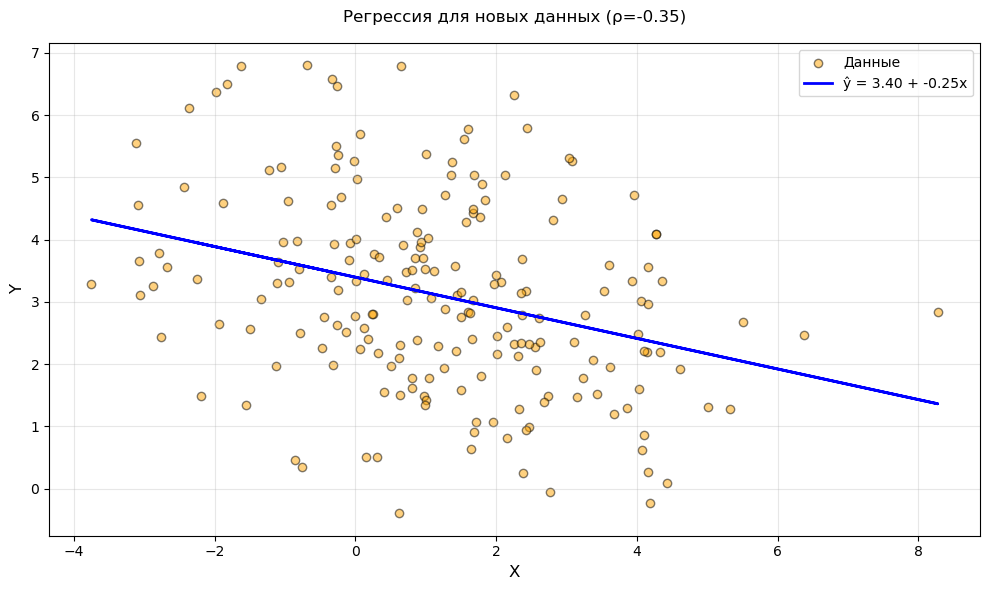

In [27]:
beta1_new = np.cov(X_new, Y_new, ddof=1)[0, 1] / np.var(X_new, ddof=1)
beta0_new = mu_y_new_hat - beta1_new * mu_x_new_hat

plt.figure(figsize=(10,6))
plt.scatter(X_new, Y_new, 
           alpha=0.5, 
           label='Данные',
           color='orange',
           edgecolor='k')
plt.plot(X_new, beta0_new + beta1_new*X_new, 
        'b-', 
        linewidth=2, 
        label=f'ŷ = {beta0_new:.2f} + {beta1_new:.2f}x')
plt.title(f'Регрессия для новых данных (ρ={rho_new:.2f})', pad=15)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

2г) Точечный прогноз

In [28]:
x_new = 4.0  # Новое значение X для прогноза
y_pred = beta0_new + beta1_new * x_new  # Точечная оценка
print(f"\n[2г] Прогноз при X={x_new}: {y_pred:.3f}")


[2г] Прогноз при X=4.0: 2.413


2д) Доверительный интервал для прогноза

In [29]:
# Расчет стандартной ошибки прогноза
n_new = len(X_new)
x_mean_new = np.mean(X_new)
var_x_new = np.var(X_new, ddof=1)
MSE = np.sum((Y_new - (beta0_new + beta1_new*X_new))**2)/(n_new - 2)  # Оценка σ²

# Стандартная ошибка для индивидуального прогноза
SE = np.sqrt(MSE * (1 + 1/n_new + (x_new - x_mean_new)**2 / ((n_new-1)*var_x_new)))

# Квантиль t-распределения
alpha = 0.05  # Уровень значимости 95%
t_crit = t.ppf(1 - alpha/2, df=n_new-2)  # Критическое значение

# Границы интервала
CI_lower = y_pred - t_crit * SE
CI_upper = y_pred + t_crit * SE

print(f"\n[2д] 95% доверительный интервал:")
print(f"[{CI_lower:.3f}, {CI_upper:.3f}]")
print(f"Ширина интервала: {CI_upper - CI_lower:.3f}")


[2д] 95% доверительный интервал:
[-0.519, 5.345]
Ширина интервала: 5.863


2е) Визуализация доверительных интервалов

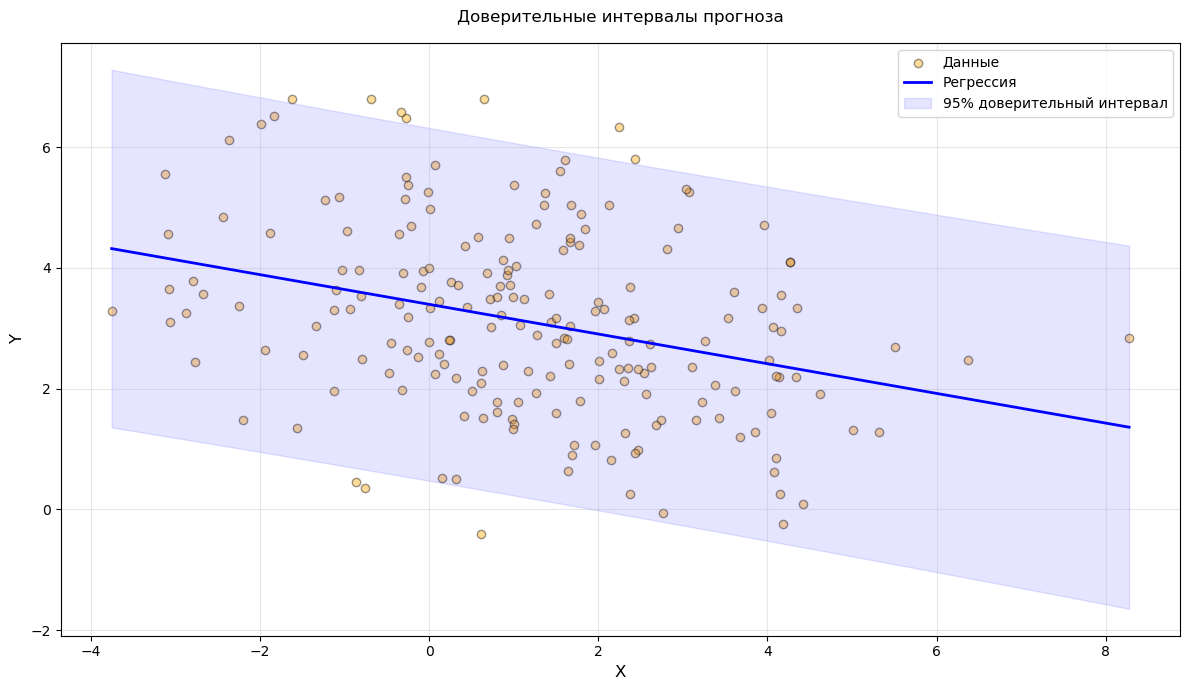

In [30]:
x_range = np.linspace(X_new.min(), X_new.max(), 100)  # Диапазон X для прогноза
SE_range = np.sqrt(MSE * (1 + 1/n_new + (x_range - x_mean_new)**2 / ((n_new-1)*var_x_new)))
CI_range = t_crit * SE_range  # Границы для всего диапазона

plt.figure(figsize=(12,7))
plt.scatter(X_new, Y_new, 
           alpha=0.4, 
           color='orange',
           edgecolor='k',
           label='Данные')
plt.plot(x_range, beta0_new + beta1_new*x_range, 
        'b-', 
        linewidth=2, 
        label='Регрессия')
plt.fill_between(x_range, 
                 beta0_new + beta1_new*x_range - CI_range,
                 beta0_new + beta1_new*x_range + CI_range,
                 color='blue', 
                 alpha=0.1,
                 label='95% доверительный интервал')
plt.title('Доверительные интервалы прогноза', pad=15)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Общая структура кода
Код решает две задачи:

Задание 1: Имитация данных → Построение линейной регрессии → Анализ параметров.
Задание 2: Прогнозирование на новых данных → Расчет доверительных интервалов.

1а) Генерация данных

Цель: Создать искусственные данные с контролируемой корреляцией для экспериментов.

Метод:

Используется multivariate_normal для генерации пар (X,Y) с заданными:

mu = [0, 2] → Средние значения X и Y.

cov_matrix → Рассчитывается через ρ, σ_X, σ_Y для управления корреляцией.


1б) Оценка параметров

mu_x_hat, mu_y_hat: Выборочные средние (оценки μ_X и μ_Y).

var_x_hat, var_y_hat: Несмещенные дисперсии (деление на n-1 через ddof=1).

1в) МНК-регрессия

Формулы:
β₁ = Cov(X,Y) / Var(X) → Наклон линии регрессии.

β₀ = μ_Y - β₁·μ_X → Сдвиг по вертикали.

Визуализация: Линия регрессии накладывается на scatter plot для проверки адекватности.

1г) Корреляция

Два метода:

Через коэффициент регрессии: ρ = β₁·(σ_X/σ_Y).

Через коэффициент Пирсона (pearsonr).

Цель: Проверить эквивалентность подходов.

1д) Качество модели

R² (R-квадрат): Доля объясненной дисперсии (1 - SSE/SST).

График остатков: Проверка на гомоскедастичность (равномерный разброс вокруг нуля).

1е) Эксперимент с объемом выборки

Цель: Показать, что с ростом n оценки β₀ и β₁ сходятся к истинным значениям (закон больших чисел)

Задание 2: Прогнозирование

2а-2б) Новая генерация

Отличие от Задания 1: Параметры (μ, σ, ρ) выбираются случайно → Проверка обобщения модели.

2в) Регрессия

Повторение шагов 1в, но на новых данных → Демонстрация универсальности метода.

2г-2д) Прогноз и доверительный интервал

Точечный прогноз: ŷ = β₀ + β₁·x_new.

t α/2 — критическое значение t-распределения с (n-2) степенями свободы.

2е) Визуализация CI

Лента доверия: Показывает область, где с вероятностью 95% будут находиться новые наблюдения.